In [5]:
!pip install scikit-image

  Using cached networkx-2.5-py3-none-any.whl (1.6 MB)


In [7]:
!pip install lime

  Using cached scikit_learn-0.23.2-cp38-cp38-win_amd64.whl (6.8 MB)
  Using cached joblib-0.16.0-py3-none-any.whl (300 kB)
  Using cached threadpoolctl-2.1.0-py3-none-any.whl (12 kB)
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283850 sha256=369a23cb9022828c4f87d20663852bc9e6d97d418ba5a3ada78462cfbb860b44
  Stored in directory: c:\users\kwu06\appdata\local\pip\cache\wheels\e6\a6\20\cc1e293fcdb67ede666fed293cb895395e7ecceb4467779546
Successfully built lime


In [12]:
!pip install opencv-python

In [13]:
from keras.layers import Dense, Flatten, AveragePooling2D, Dropout
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from skimage.segmentation import mark_boundaries
import lime
from lime import lime_imagex
import cv2

In [14]:
data_path = './Xray/Data'

In [15]:
baseModel = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)

58892288/58889256 [==============================] - 2s 0us/step


In [16]:
for layer in baseModel.layers:
    layer.trainable = False

headModel = baseModel.output
headModel = AveragePooling2D()(headModel)
headModel = Flatten()(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(3, activation='softmax')(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)


In [17]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [18]:
from keras.optimizers import Adam
opt=Adam(learning_rate=0.0001)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

In [19]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   zoom_range = 0.2,
                                   rotation_range=15,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(data_path + '/train',
                                                 target_size = (224, 224),
                                                 batch_size = 16,
                                                 class_mode = 'categorical',
                                                 shuffle=True)

test_set = test_datagen.flow_from_directory(data_path + '/test',
                                            target_size = (224, 224),
                                            batch_size = 16,
                                            class_mode = 'categorical',
                                            shuffle = False)


Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


In [21]:
history = model.fit_generator(training_set,
                              validation_data=test_set,
                              epochs=5)   

Epoch 1/5
322/322 [==============================] - 126s 391ms/step - loss: 0.2171 - accuracy: 0.9253 - val_loss: 0.2088 - val_accuracy: 0.9177
Epoch 2/5
322/322 [==============================] - 132s 409ms/step - loss: 0.1855 - accuracy: 0.9335 - val_loss: 0.2218 - val_accuracy: 0.9099
Epoch 3/5
322/322 [==============================] - 132s 410ms/step - loss: 0.1798 - accuracy: 0.9386 - val_loss: 0.1688 - val_accuracy: 0.9286
Epoch 4/5
322/322 [==============================] - 133s 412ms/step - loss: 0.1608 - accuracy: 0.9432 - val_loss: 0.1790 - val_accuracy: 0.9270
Epoch 5/5
322/322 [==============================] - 132s 411ms/step - loss: 0.1558 - accuracy: 0.9469 - val_loss: 0.1881 - val_accuracy: 0.9231


In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=range(len(acc))

Text(0.5, 1.0, 'Training and Validation Accuracy')

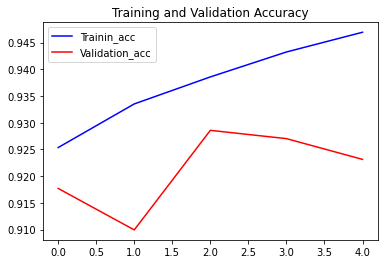

In [23]:
plt.plot(epochs,acc,label='Trainin_acc',color='blue')
plt.plot(epochs,val_acc,label='Validation_acc',color='red')
plt.legend()
plt.title("Training and Validation Accuracy")

Text(0.5, 1.0, 'Training and Validation loss')

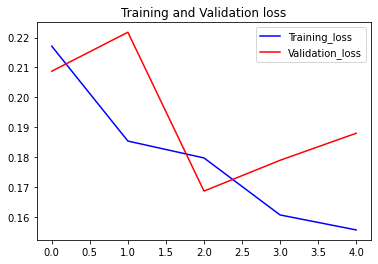

In [24]:
plt.plot(epochs,loss,label='Training_loss',color='blue')
plt.plot(epochs,val_loss,label='Validation_loss',color='red')
plt.legend()
plt.title("Training and Validation loss")

In [25]:
class_dict = {0:'COVID19',
              1:'NORMAL',
              2:'PNEUMONIA'}

prediction:  COVID19


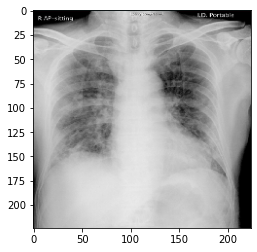

In [27]:
file_path =  '/test/COVID19/COVID19(114).jpg'
test_image = cv2.imread(data_path + file_path)
test_image = cv2.resize(test_image, (224,224),interpolation=cv2.INTER_NEAREST)
plt.imshow(test_image)
test_image = np.expand_dims(test_image,axis=0)
probs = model.predict(test_image)
pred_class = np.argmax(probs)

pred_class = class_dict[pred_class]

print('prediction: ',pred_class)

In [28]:
def find_true_class(file_path):
    true_class = None
    if 'COVID19' in file_path:
        true_class = 'COVID19'
    elif 'PNEUMONIA' in file_path:
        true_class = 'PNEUMONIA'
    elif 'NORMAL' in file_path:
        true_class = 'NORMAL'
    return true_class

In [29]:
def visualize(file_path,ax,text_loc):
    test_image = cv2.imread(data_path + file_path)
    test_image = cv2.resize(test_image, (224,224),interpolation=cv2.INTER_NEAREST)
    test_image = np.expand_dims(test_image,axis=0)
    probs = model.predict(test_image)
    pred_class = np.argmax(probs)
    pred_class = class_dict[pred_class]

    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(test_image[0], model.predict, top_labels=5, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)


    ax.imshow(mark_boundaries(temp, mask))
    fig.text(text_loc, 0.9, "Predicted Class: " + pred_class , fontsize=13)
    true_class = find_true_class(file_path)
    if true_class is not None:
        fig.text(text_loc, 0.86, "Actual Class: " + true_class , fontsize=13)

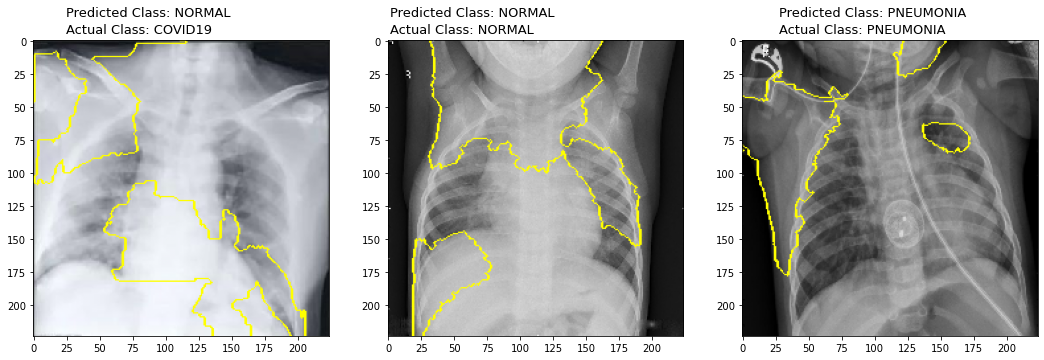

In [31]:
fig,ax = plt.subplots(1,3,figsize=(18,6))
visualize('/test/COVID19/COVID19(116).jpg',ax[0],0.15)
visualize('/test/NORMAL/NORMAL(317).jpg',ax[1],0.4)
visualize('/test/PNEUMONIA/PNEUMONIA(852).jpg',ax[2],0.7)

In [32]:
model.save('covid_model.h5')